In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 22.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver d

# 라이브러리

In [ ]:
# 파이썬 서드파티 라이브러리
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_text # tf.saved_model.load로 dataset의 tokenizer를 불러올 때 필요
import tensorflow as tf

# 클래스

## 위치 임베딩

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    @staticmethod
    def positional_encoding(length: int, depth: int) -> tf.Tensor:
        """고정된 위치 인코딩 결과값을 출력하는 함수

        Args:
            length: 입력 시퀀스의 길이 -> int
            depth: 출력 크기

        Returns:
            tf.Tensor
        """
        depth = depth / 2

        positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
        depths = np.arange(depth)[np.newaxis, :] / depth   # (1, depth)

        angle_rates = 1 / (10000**depths)         # (1, depth)
        angle_rads = positions * angle_rates      # (pos, depth)

        pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

        return tf.cast(pos_encoding, dtype=tf.float32)

    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=d_model, mask_zero=True)
        self.pos_encoding = PositionalEmbedding.positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

## 베이스 어텐션

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

## 크로스 어텐션

In [ ]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
                                            query=x,
                                            key=context,
                                            value=context,
                                            return_attention_scores=True)

        # 추후에 어텐션 점수 시각화를 위한 변수
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

## 글로벌 셀프 어텐션

In [ ]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
                              query=x,
                              value=x,
                              key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

## 코잘 셀프 어텐션

In [ ]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
                              query=x,
                              value=x,
                              key=x,
                              use_causal_mask=True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

## 피드 포워드 레이어

In [ ]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
                                        tf.keras.layers.Dense(units=dff, activation='swish', kernel_initializer="he_normal"),
                                        tf.keras.layers.Dense(units=d_model, activation='swish', kernel_initializer="he_normal"),
                                        tf.keras.layers.Dropout(rate=dropout_rate)
                                      ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

## 인코더 레이어

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(
                                                  num_heads=num_heads,
                                                  key_dim=d_model,
                                                  dropout=dropout_rate)
        self.ffn = FeedForward(d_model=d_model, dff=dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

## 인코더

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
                            EncoderLayer(d_model=d_model,
                                        num_heads=num_heads,
                                        dff=dff,
                                        dropout_rate=dropout_rate)
                            for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

    def call(self, x):
        # `x` -> token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

## 디코더 레이어

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
                *,
                d_model,
                num_heads,
                dff,
                dropout_rate=0.1):
      super().__init__()
      self.causal_self_attention = CausalSelfAttention(
                                                      num_heads=num_heads,
                                                      key_dim=d_model,
                                                      dropout=dropout_rate)
      self.cross_attention = CrossAttention(
                                            num_heads=num_heads,
                                            key_dim=d_model,
                                            dropout=dropout_rate)
      self.ffn = FeedForward(d_model=d_model, dff=dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # 추후에 어텐션 점수 시각화를 위한 변수
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

## 디코더

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
                dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        self.dec_layers = [
                            DecoderLayer(d_model=d_model, num_heads=num_heads,
                                        dff=dff, dropout_rate=dropout_rate)
                            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` -> token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x -> (batch_size, target_seq_len, d_model).
        return x

## 트랜스포머

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
                input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                              num_heads=num_heads, dff=dff,
                              vocab_size=input_vocab_size,
                              dropout_rate=dropout_rate)
        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                              num_heads=num_heads, dff=dff,
                              vocab_size=target_vocab_size,
                              dropout_rate=dropout_rate)
        self.final_layer = tf.keras.layers.Dense(units=target_vocab_size)

    def call(self, inputs):
        context, x  = inputs
        context = self.encoder(context)  # (batch_size, context_len, d_model)
        x = self.decoder(x, context)  # (batch_size, target_len, d_model)
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # losses/metrics가 커지지 않게 keras_mask를 제거
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

## 1사이클 스케줄링

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

## 번역기

In [ ]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer

    def __call__(self, sentence, max_length):
        # input sentence는 포르투칼어로 [START]와 [END]토큰을 추가
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]

        sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
        encoder_input = sentence

        # 출력 언어는 영어이기 때문에 [START] 토큰으로 시작
        start_end = self.tokenizers.en.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        # 파이썬 리스트 대신에 tf.TensorArray를 사용
        # 이를 통해 tf.function으로 dynamic-loop 추적 가능
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([encoder_input, output], training=False)

            # `seq_len` 차원에서 마지막 토큰을 선택
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.
            predicted_id = tf.argmax(predictions, axis=-1)

            output_array = output_array.write(i + 1, predicted_id[0])

            if predicted_id == end:
                break

        output = tf.transpose(output_array.stack())
        # output shape -> `(1, tokens)`.
        text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

        tokens = tokenizers.en.lookup(output)[0]

        # tf.function으로 루프의 마지막 반복에서 계산된 attention_weights가 사용되지 않게 예방
        # 이를 통해 루프 외부에서 재계산
        self.transformer([encoder_input, output[:,:-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, tokens, attention_weights

## 확장 번역기

In [ ]:
class ExportTranslator(tf.Module):
    def __init__(self, translator):
        self.translator = translator

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, sentence):
        (result,
        tokens,
        attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

        return result

# 함수

In [ ]:
def prepare_tokenizer(tokenizers, MAX_TOKENS):
    def prepare_batch(pt, en):
        pt = tokenizers.pt.tokenize(pt)      # Ragged Tensor가 출력
        pt = pt[:, :MAX_TOKENS]    # MAX_TOKENS으로 자르기
        pt = pt.to_tensor()  # 제로 패딩한 텐서로 전환

        en = tokenizers.en.tokenize(en)
        en = en[:, :(MAX_TOKENS + 1)]
        en_inputs = en[:, :-1].to_tensor()  # [END] 토큰 제거
        en_labels = en[:, 1:].to_tensor()   # [START] 토큰 제거

        return (pt, en_inputs), en_labels
    return prepare_batch

In [ ]:
# tf.data.Dataset을 배치하는 함수
def make_batches(ds: tf.data.Dataset, tokenizers: tf.Module, MAX_TOKENS: int, BUFFER_SIZE: int, BATCH_SIZE: int):
    """tf.data.Dataset을 배치 크기만큼 적용하는 함수

    Args:
        ds: tf.data.Dataset
        tokenizers: tfds로 불러온 토크나이저 -> tf.Module
        MAX_TOEKNS: 최대 토큰 길이 -> int
        BUFFER_SIZE: 버퍼 크기 -> int
        BATCH_SIZE: 배치 크기 -> int

    Return
        tf.data.Dataset
    """
    ds = ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    ds = ds.map(prepare_tokenizer(tokenizers=tokenizers, MAX_TOKENS=MAX_TOKENS), tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [ ]:
# 마스킹된 손실함수
def masked_loss(label: tf.Tensor, pred: tf.Tensor) -> float:
    """마스킹을 포함한 예측값과 실제값의 손실값을 계산하는 함수

    Args:
        label: 실제값 -> tf.Tensor
        pred: 예측값 -> tf.Tensor

    Returns:
        손실값 -> float
    """
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(y_true=label, y_pred=pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(input_tensor=loss) / tf.reduce_sum(input_tensor=mask)
    return loss

# 마스킹된 정확도 함수
def masked_accuracy(label: tf.Tensor, pred: tf.Tensor) -> float:
    """마스킹을 포함한 예측값과 실제값의 정확도를 계산하는 함수

    Args:
        label: 실제값 -> tf.Tensor
        pred: 예측값 -> tf.Tensor

    Returns:
        정확도 -> float
    """
    pred = tf.argmax(input=pred, axis=2)
    label = tf.cast(label, dtype=pred.dtype)
    matched = label == pred

    mask = label != 0

    matched = matched & mask

    matched = tf.cast(matched, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(input_tensor=matched) / tf.reduce_sum(input_tensor=mask)

In [ ]:
# 번역 비교 함수
def print_translation(sentence: str, tokens: tf.Tensor, ground_truth: str) -> None:
    """입력 텍스트 문자열과 예측 텍스트 문자열, 실제 텍스트 문자열을 출력 비교하는 함수

    Args:
        sentence: 입력 텍스트 문자열 -> str
        tokens: 예측 인코딩 텐서 -> tf.Tensor
        ground_truth: 실제 비교 텍스트 문자열 -> str
    """
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

# 변수

In [ ]:
SEED = 1234
tf.random.set_seed(SEED)

MAX_TOKENS = 128

BUFFER_SIZE = 20000
BATCH_SIZE = 64

# 데이터

## 데이터 다운로드

이 데이터는 52,000개의 학습 데이터와 1,800개의 검증 데이터 및 1,200개의 테스트 데이터로 구성

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.I8735R_1.0.0/ted_hrlr_translate-tra…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.I8735R_1.0.0/ted_hrlr_translate-val…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.I8735R_1.0.0/ted_hrlr_translate-tes…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


## 데이터 토크나이저 다운로드

In [ ]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
                        f'{model_name}.zip',
                        f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
                        cache_dir='.', cache_subdir='', extract=True
                        )

184801/184801 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [ ]:
tokenizers = tf.saved_model.load(model_name)

## 토큰화 길이 시각화

In [ ]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
    pt_tokens = tokenizers.pt.tokenize(pt_examples)
    lengths.append(pt_tokens.row_lengths())

    en_tokens = tokenizers.en.tokenize(en_examples)
    lengths.append(en_tokens.row_lengths())

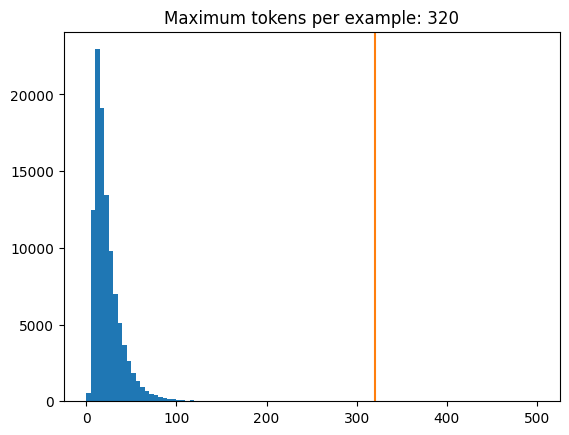

In [ ]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}')
plt.show()

## 데이터셋 생성

In [ ]:
train_batches = make_batches(train_examples, tokenizers=tokenizers,
                             MAX_TOKENS=MAX_TOKENS, BUFFER_SIZE=BUFFER_SIZE,
                             BATCH_SIZE=BATCH_SIZE)
val_batches = make_batches(val_examples, tokenizers=tokenizers,
                           MAX_TOKENS=MAX_TOKENS, BUFFER_SIZE=BUFFER_SIZE,
                           BATCH_SIZE=BATCH_SIZE)

# 각 레이어 출력 크기

In [ ]:
for (pt, en), en_labels in train_batches.take(1):
    break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 73)
(64, 69)
(64, 69)


In [ ]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size().numpy(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size().numpy(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [ ]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 69), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

In [ ]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 73, 512)
(64, 69, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 69, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'cross_attention' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 73, 512)
(64, 73, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_self_attention' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 69, 512)
(64, 69, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'causal_self_attention' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 69, 512)
(64, 69, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'feed_forward' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_self_attention_1' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 73, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'feed_forward_1' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 73, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'encoder_layer' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_self_attention_2' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential_2' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'feed_forward_2' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(

(64, 73)
(64, 73, 512)


In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)
sample_decoder_layer_output = sample_decoder_layer(x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'causal_self_attention_1' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'cross_attention_1' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential_6' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings

(64, 69, 512)
(64, 73, 512)
(64, 69, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'decoder_layer' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(x=en, context=pt_emb)

print(en.shape)
print(pt_emb.shape)
print(output.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'causal_self_attention_2' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential_7' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings

(64, 69)
(64, 73, 512)
(64, 69, 512)


In [ ]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 69, 73])

# 모델

## 트랜스포머

### 하이퍼 파라미터

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [ ]:
transformer = Transformer(
                          num_layers=num_layers,
                          d_model=d_model,
                          num_heads=num_heads,
                          dff=dff,
                          input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
                          target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
                          dropout_rate=dropout_rate)

In [ ]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_self_attention_6' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential_11' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'feed_forward_11' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.war

(64, 69)
(64, 73)
(64, 69, 7010)


In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 69, 73)


In [ ]:
learning_rate = CustomSchedule(d_model=d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

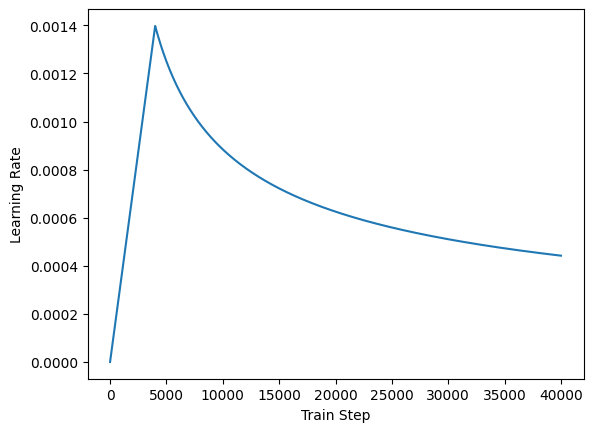

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [ ]:
transformer.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])

## 트랜스포머 학습

In [ ]:
# GPU가 있어도 시간이 오래걸림
transformer.fit(train_batches, epochs=20, validation_data=val_batches)

# 번역

In [ ]:
translator = Translator(tokenizers=tokenizers, transformer=transformer)

In [ ]:
# Example 1:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence), max_length=MAX_TOKENS)
print_translation(sentence, translated_text, ground_truth)

In [ ]:
# Example 2:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence), max_length=MAX_TOKENS)
print_translation(sentence, translated_text, ground_truth)

In [ ]:
# Example 3:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence), max_length=MAX_TOKENS)
print_translation(sentence, translated_text, ground_truth)

In [ ]:
# Example 4:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence), max_length=MAX_TOKENS)
print_translation(sentence, translated_text, ground_truth)

In [ ]:
translator = ExportTranslator(translator)

In [ ]:
translator('este é o primeiro livro que eu fiz.').numpy()